In [1]:
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = "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"
os.environ['AZURE_OPENAI_API_KEY'] = os.getenv("AZURE_OPENAI_API_KEY")

In [4]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    model="gpt_4o",
    azure_deployment="odda_gpt",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    openai_api_type=os.getenv("AZURE_OPENAI_API_TYPE"),
    api_version=os.getenv("AZURE_OPENAI_VERSION"),
    temperature=0
)



In [ ]:
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

In [ ]:
def add_one(input: list[HumanMessage]):
    input[0].content = input[0].content + "a"
    return input

graph = MessageGraph()

graph.add_node("branch_a", add_one)
graph.add_edge("branch_a","branch_b")
graph.add_edge("branch_a","branch_c")

graph.add_node("branch_b", add_one)
graph.add_node("branch_c", add_one)

graph.add_edge("branch_c","final_node")
graph.add_edge("branch_b","final_node")

graph.add_node("final_node", add_one)
graph.add_edge("final_node",END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [ ]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))

In [ ]:
runnable.invoke("a")

In [ ]:
from langgraph.graph import MessageGraph, END
from langchain_core.messages import HumanMessage

def entry(input: list[HumanMessage]):
    return input

def work_with_b(input: list[HumanMessage]):
    print("Using Branch B")
    return input

def work_with_c(input: list[HumanMessage]):
    print("Using Branch C")
    return input

def router(input: list[HumanMessage]):
    if "use_b" in input[0].content:
        return "branch_b"
    else:
        return "branch_c"
    
graph = MessageGraph()

graph.add_node("branch_a", entry)
graph.add_node("branch_b", work_with_b)
graph.add_node("branch_c", work_with_c)

graph.add_conditional_edges(
    "branch_a",
    router,
    {"branch_b":"branch_b","branch_c":"branch_c"}
)

graph.add_edge("branch_b", END)
graph.add_edge("branch_c", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [ ]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))

In [ ]:
runnable.invoke("I think for this one you should try branch c")

In [ ]:
runnable.invoke("I think for this one you should try branch c, how are you?")

In [ ]:
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

llm = AzureChatOpenAI(
    model="gpt_4o",
    azure_deployment="odda_gpt",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    openai_api_type=os.getenv("AZURE_OPENAI_API_TYPE"),
    api_version=os.getenv("AZURE_OPENAI_VERSION"),
    temperature=0
)

def entry(input: list[HumanMessage]):
    return input

def action(input: list[HumanMessage]):
    print("Action taken:", [msg.content for msg in input])
    if len(input) > 5:
        input.append(HumanMessage(content="end"))
    else:
        input.append(HumanMessage(content="continue"))
    return input

def should_continue(input: list):
    last_message = input[-1]
    if "end" in last_message.content:
        return "__end__"
    return "action"


graph = MessageGraph()

graph.add_node("agent", entry)
graph.add_node("action", action)

graph.add_conditional_edges(
    "agent",
    should_continue,
    {"action":"action","__end__":END}
)

graph.set_entry_point("agent")
graph.add_edge("action","agent")

runnable = graph.compile()

In [ ]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))

In [ ]:
runnable.invoke("one")

In [5]:
## We will also now create a custom state
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    api_call_count: int = 0

In [10]:
### now we need to create the tool from Langchain 

from langchain_core.tools import tool
# from langchain_community.tools.tavily_search import TavilySearchResults

# os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

# tools = [TavilySearchResults(max_results=1)]

import random


@tool
def fake_weather_api(city: str) -> str:
    """Check the weather in a specified city. The API is available randomly, approximately every third call."""

    if random.randint(1, 2) == 1:  # Approximately one-third chance
        return "Sunny, 22°C"
    else:
        return "Rainy, 4°C"





In [22]:
print(fake_weather_api("New York"))
print(fake_weather_api("London"))
print(fake_weather_api("Berlin"))

Rainy, 4°C
Sunny, 22°C
Sunny, 22°C


In [23]:
llm_with_tools = llm.bind_tools([fake_weather_api])

In [24]:
from langchain_core.messages import HumanMessage, ToolMessage

tool_mapping = {"fake_weather_api": fake_weather_api}

messages = [HumanMessage("How will the weather be in Munich today? I would like to eat outdoors if possible.")]

llm_output = llm_with_tools.invoke(messages)

messages.append(llm_output)

print(messages)

[HumanMessage(content='How will the weather be in Munich today? I would like to eat outdoors if possible.'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_SD82HJXIAH9xgNvdGjj3ov7f', 'function': {'arguments': '{"city":"Munich"}', 'name': 'fake_weather_api'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 75, 'total_tokens': 91}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_36b0c83da2', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-666791aa-2be9-49d7-897c-b877fa90a40d-0', tool_calls=[{'name': 'fake_weather_api', 'args': {'city': 'Munich'}, 'id': 'call_SD82HJXIAH9xgNvdGjj3ov7f', 

In [ ]:
for tool_call in llm_output.tool_calls:
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    messages.append(ToolMessage(content=tool_output, tool_call_id=tool_call["id"]))

llm_with_tools.invoke(messages)

In [29]:
def should_continue(state: AgentState):
    print("STATE:", state)
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"
    
def call_model(state: AgentState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages":[response], "api_call_count":state["api_call_count"]}

def call_tool(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    tool_call = last_message.tool_calls[0]
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    state["api_call_count"] += 1
    print("Tool output:", tool_output)
    print("API call count after this tool call:", state["api_call_count"])
    tool_message = ToolMessage(content=tool_output, tool_call_id=tool_call["id"])
    return {"messages": [tool_message], "api_call_count": state["api_call_count"]}


In [30]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue":"action",
        "end":END,
    }
)

workflow.add_edge("action","agent")

app = workflow.compile()

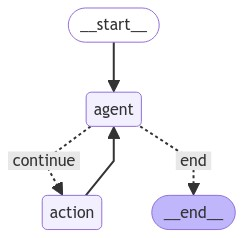

In [31]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [32]:
from langchain_core.messages import SystemMessage

system_message = SystemMessage(
    content="You are responsible for answering user questions. You use tools for that, These tools sometimes fail and you are very resilient and trying them again"
)
human_message = HumanMessage(content="How is the weather in munich today?")
messages = [system_message, human_message]

result = app.invoke({"messages": messages, "api_call_count": 0})

STATE: {'messages': [SystemMessage(content='You are responsible for answering user questions. You use tools for that, These tools sometimes fail and you are very resilient and trying them again'), HumanMessage(content='How is the weather in munich today?'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ent5bL7TrJev9mZl37eXnijM', 'function': {'arguments': '{"city":"munich"}', 'name': 'fake_weather_api'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 94, 'total_tokens': 110}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_36b0c83da2', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run

In [33]:
print(result["messages"][-1].content)
print(result["api_call_count"])

The weather in Munich today is sunny with a temperature of 22°C. Enjoy your day!
1
